In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from __future__ import absolute_import, division, print_function

import re
import os
import sys
import datetime
import itertools
import warnings

import pandas as pd
import pandas_datareader.data as web
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
#from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

# remove warnings
import warnings
warnings.filterwarnings('ignore')

# prevent crazy long pandas prints
pd.options.display.max_columns = 16
pd.options.display.max_rows = 16
pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(precision=5, suppress=True)

# Display and Plotting
import matplotlib.pyplot as plt
#set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 80
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 16, 8
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['text.usetex'] = False
#plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"
plt.rcParams['text.latex.preamble'] = b"\usepackage{subdepth}, \usepackage{type1cm}"

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})


from ipywidgets import interactive, widgets, RadioButtons, ToggleButtons, Select, FloatSlider, FloatProgress

from IPython.display import set_matplotlib_formats, Image

C:\Users\DEDACAT1\AppData\Local\conda\conda\envs\python35\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# 2. Time Series Basics

A time series is a series of data points indexed (or listed or graphed) in time order. Most commonly, a time series is a sequence taken at successive equally spaced points in time. Thus it is a sequence of discrete-time data. - <a href="https://en.wikipedia.org/wiki/Time_series">Wikipedia</a>

Time series are different from predictive classification and regression problems in that they exhibit a an additional temporal structure. On account of this structure the literature has identified assumptions about the consistency of data points from time series which need to be handeled with care.

## 2.1 Data generating process

A time series is a sequence of observations $y_1, \dots, y_T$ which are equally spaced along a time axis according to a frequency of observation (e.g. daily, monthly, yearly, etc). 

An observed time series, denoted $\{y_t\}_{t=1}^{T}$, is assumed to stem from an unobservable<strong>data generating process</strong>.

A parametric modelling approach to time series analysis makes the fundamental assumption that the underlying data generating process is a <strong>stationary stochastic process</strong>. That is, the process has a certain structure which can be described by using a number of parameters (e.g autoregressive or moving average models).

## 2.2 Concept of stationarity

In [2]:
Image(filename=('C:/Users/DEDACAT1/Desktop/Learning/Python/data-science-toolox/stationarity.png'))

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/DEDACAT1/Desktop/Learning/Python/data-science-toolox/stationarity.png'

A stochastic process $\{y_t\}_{t=1}^{T}$ is called strongly stationary if the distribution of $\{y_{t+s}\}_{t=1}^{T}$ for $s \in T$ is exactely the as the distribution of $\{y_t\}_{t=1}^{T}$. In other words, the distribution of original time-series is exactly same as lagged time-series (by any number of lags) or even sub-segments of the time-series. This assumption is to strict ad absolutely not applicable to time series encoutnered in real life.

A milder assumption is <strong>covariance stationarity</strong> (the type of stationarity from the picture above). A process $\{y_t\}_{t=1}^{T}$ is covariance stationary if:

<ol>
<li>$ E[y_t] = \mu < \infty $ for all $t$</li>
<li>$ V[y_t] = \sigma^2 < \infty $ for all $t$</li>
<li>$ \gamma(t, s) = \gamma[\tau] < \infty $ for all $t$ and $\tau$</li>
</ol>


## 2.3 Serial Correlation (Autocorrelation)

<strong>Autocovariance</strong> describes the covariance between two values of a stochastic process $\{y_t\}_{t=1}^T$ at different points in time:

$$
\gamma(t, s) = Cov(y_t, y_s) = E[(y_t - \mu_t)(y_s - \mu_s)]
$$

Then, the <strong>autocarrelation fucntion</strong> is given by

$$
\rho(t, s) = \frac{\gamma(t, s)}{\sigma_t\sigma_s}
$$

with $-1 < \rho(t, s) < +1$ and where $\sigma$ ist the standard deviation. This is the formalization of the third requirement of a stationary time series. Thus, when the residuals (errors) in a time series are correlated with each other it is said to exhibit erial correlation. For a stationary process the covariance is only dependent on the difference $\tau$ between $t$ and $s$

If we fail to account for this in our models later on the standard errors of our coefficients are underestimated, inflating the size of our T-statistics. The result is too many Type-1 errors, where we reject our null hypothesis even when it is True. Ignoring autocorrelation means that the model predictions will be inaccurate, and one is likely to draw incorrect conclusions about the impact of the independent variables in our model. 

The plots of the autocorrelation function (ACF) and the partial autorrelation function (PACF) are the two main tools to examine the time series dependency structure. The ACF is a function of the time displacement of the time series itself. Informally, it is the similarity between observations as a function of the time lag between them. The partial autocorrelation function is the conditional correlation between two variables under the assumptions that the effects of all previous lags on the time series are known.

## 2.4 White noise

A time series that is a white noise process has serielly uncorrelated errors and the expected mean of those errors is equal to zero. Errors are serially uncorrelated if they are independent and identically distributed (iid). This is important because if a time series model is appropriate and successful at capturing the udnerlying process, residuals of the model will be iid and resemble a white noise process.

Therefore part of time series analysis is simply trying to fit a model to a time series such that the residual series is indistinguishable white noise.

The <code>ts_plot</code> function will be used to quickly evaluate a given time series process.

In [3]:
def ts_plot(y, lags=None, title=''):
    '''
    Calculate acf, pacf, histogram, and qq plot for a given time series
    '''
    # if time series is not a Series object, make it so
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    
    # initialize figure and axes
    fig = plt.figure(figsize=(14, 12))
    layout = (3, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    qq_ax = plt.subplot2grid(layout, (2, 0))
    hist_ax = plt.subplot2grid(layout, (2, 1))
    
    # time series plot
    y.plot(ax=ts_ax)
    plt.legend(loc='best')
    ts_ax.set_title(title);
    
    # acf and pacf
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5) 
    
    # qq plot
    sm.qqplot(y, line='s', ax=qq_ax)
    qq_ax.set_title('Normal QQ Plot')
    
    # hist plot
    y.plot(ax=hist_ax, kind='hist', bins=25);
    hist_ax.set_title('Histogram');
    plt.tight_layout();
    plt.show()
    return

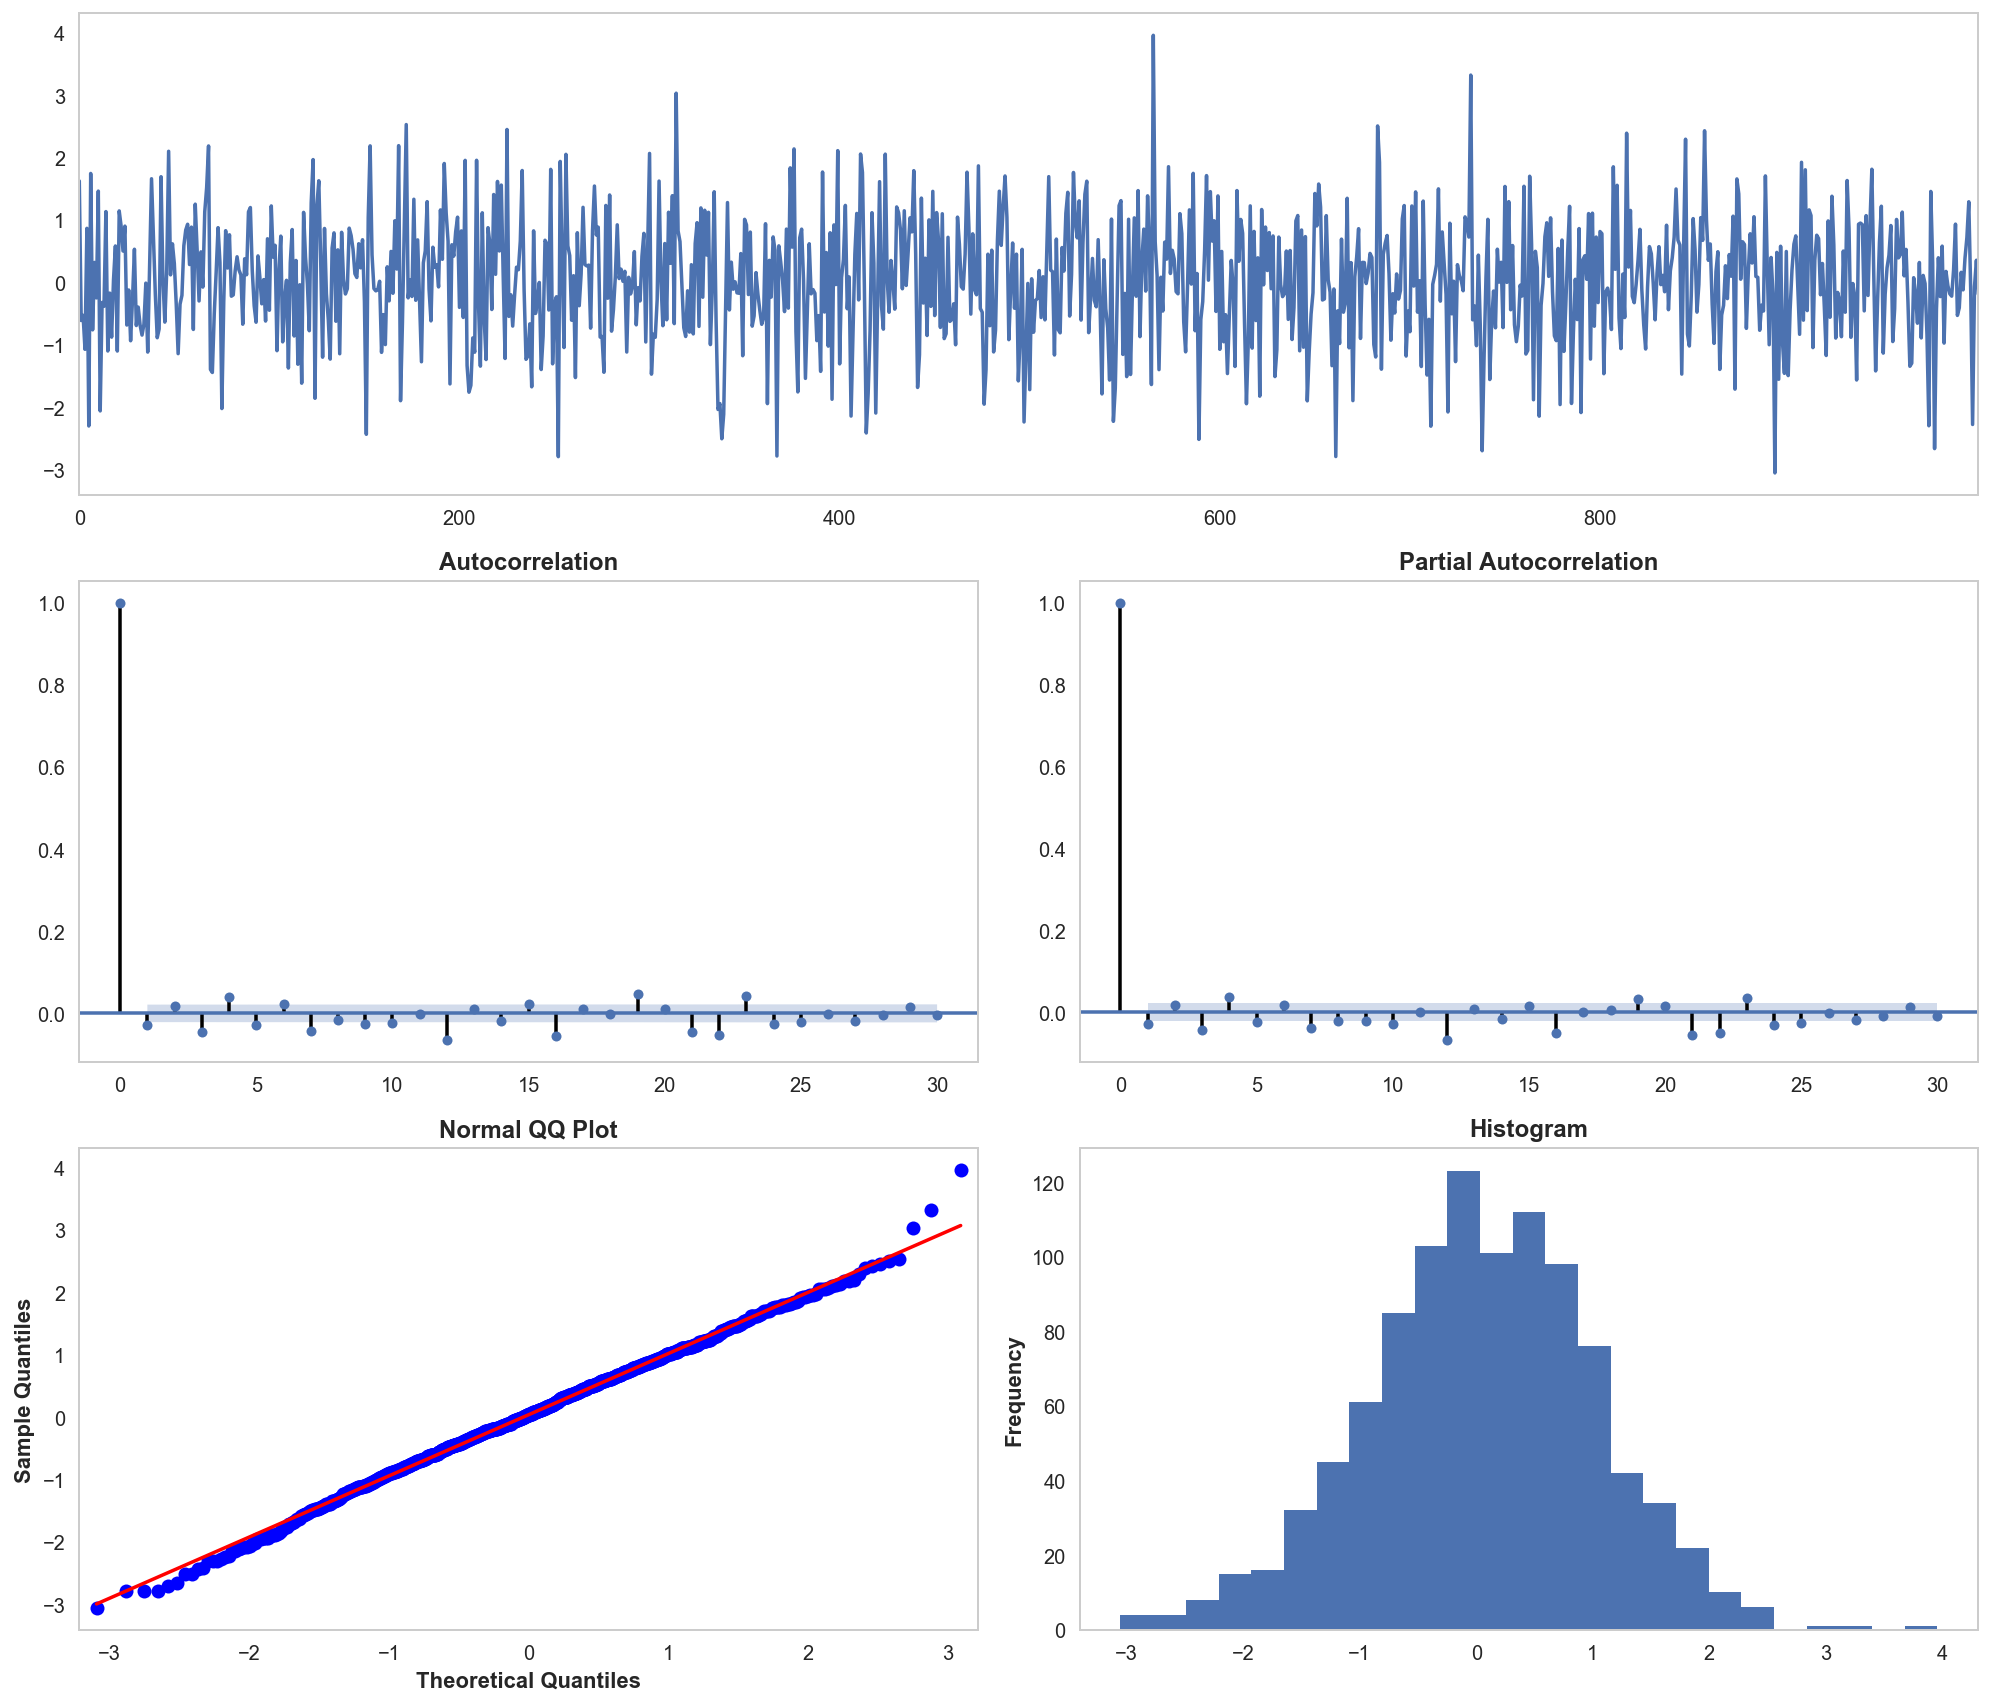

In [4]:
np.random.seed(1)

# simulate discrete white noise N(0, 1)
wn = np.random.normal(size=1000)
ts_plot(wn, lags=30)

<strong>Inference</strong>
<ul>
<li>Differences in the scale of the decomposed time series when compared to the multiplicative model</li>
<li>There is still a pattern left in the residual series</li>
<li>The high residual values indicate that the application of a multiplicative model is preferable</li>
</ul>


## 2.5  Random walk

A process $\{x_t\}_{t=1}^T$ is called a random walk process if it is of the form

$$
x_t = x_{t-1} + \omega_t
$$

where $\omega_t$ is a white noise process. What is special about the random walk is, that it is <strong>not stationary</strong>. If a given time series is governed by a random walk process it is unpredictable.

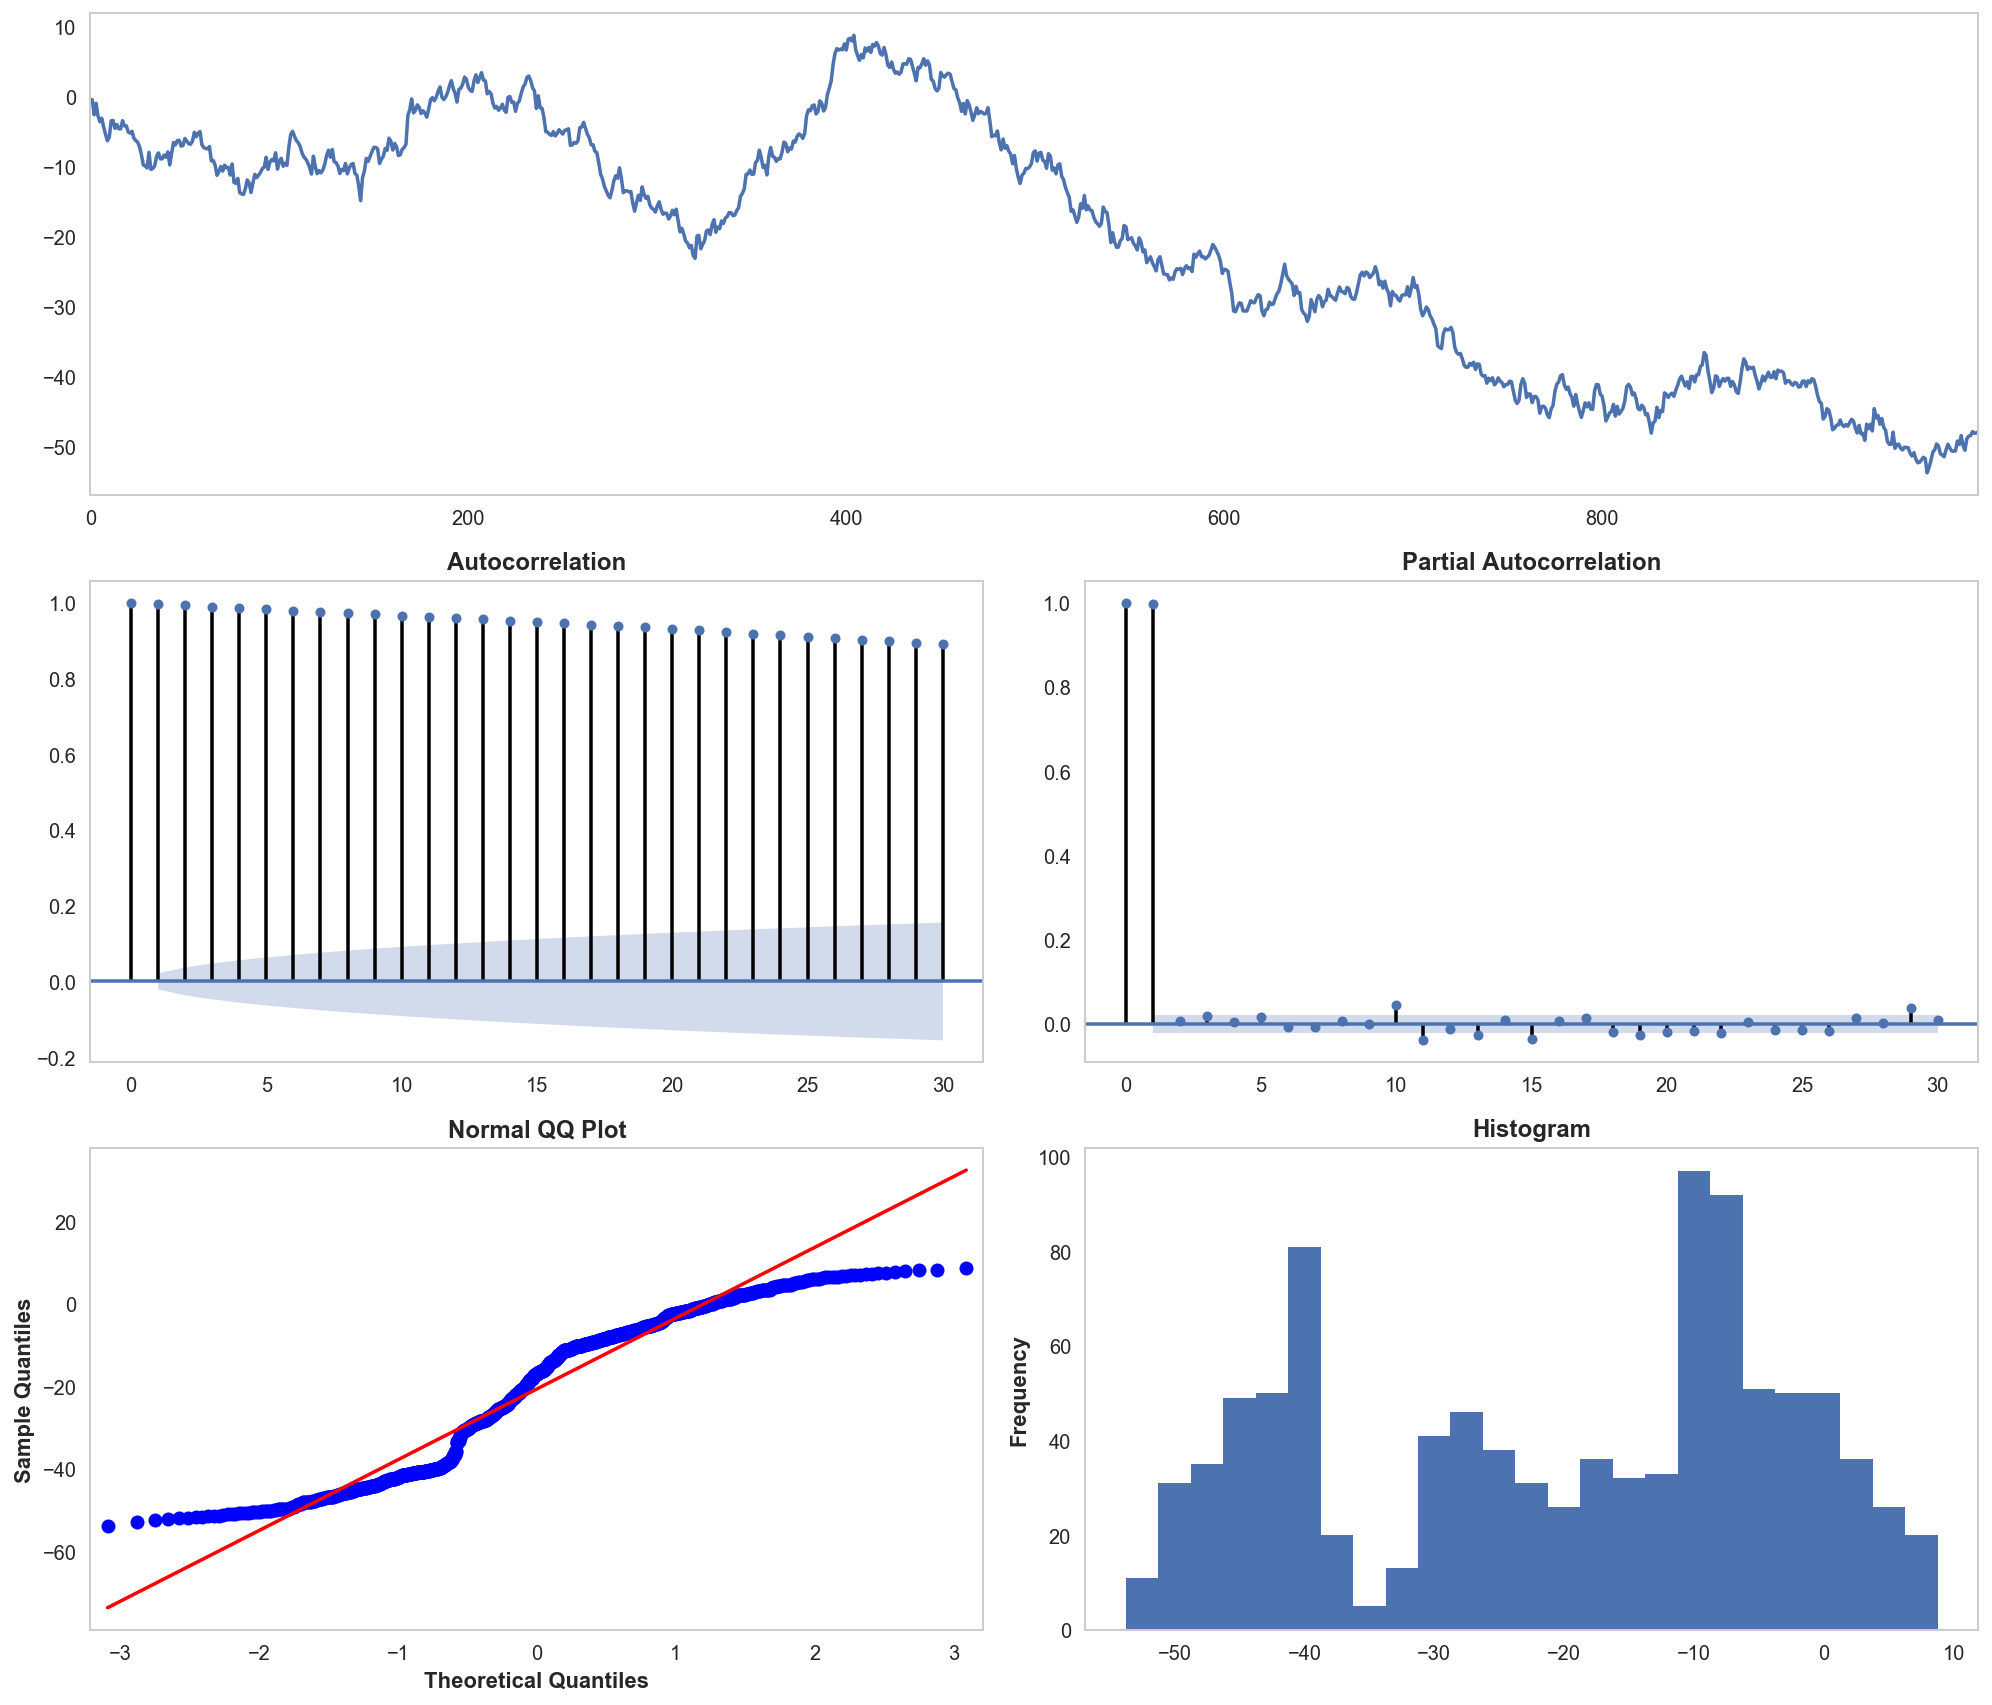

In [16]:
np.random.seed(2)

# simulate random walk

wn = np.random.normal(size=1000)
x = np.zeros_like(wn)

for t in range(1000):
    x[t] = x[t-1] + wn[t]

ts_plot(x, lags=30)

In [14]:
wn = np.random.normal(size=1000)
x = np.random.normal(size=1000)
print(x)

[ 2.16119  1.34082 -1.0878   0.34955  0.06692  2.0961   0.87971 -0.6079
  0.16865  0.28208  0.145   -1.80253 -0.78669  2.29765 -1.2251  -0.80614
  1.36247 -1.00591 -0.89136  0.01998  2.43942 -0.78493  1.63287  0.50422
 -0.41568 -1.56917 -1.34818  1.00207  0.04038 -0.1453   0.33271 -0.8655
 -0.67378 -0.129    0.45124  0.65246  2.50978  0.82808 -2.35582  0.1969
 -0.01561 -0.54321 -1.54286  1.18512 -1.38741  0.08258 -0.73328 -2.22529
  1.17337 -0.1579   0.48204  0.2862  -0.5702  -0.08721  0.47079  0.63133
  0.10154  1.18541 -1.47932  0.97336 -0.57964  1.37341  0.15855  0.89951
 -1.05065  0.93413 -0.94902  0.85681  1.06432 -0.48219  0.8478  -0.53508
  0.59491  1.3022  -0.92551 -0.99889  0.06871 -0.26576  0.23374  1.26201
 -0.77229  0.67031  0.92319  2.12521  0.22082 -0.51122  0.18084 -0.73475
 -0.51368 -0.00159 -0.40155  1.1847   1.55497 -1.53641 -0.4273  -0.01551
  1.62561 -1.1848  -0.28394  0.87135 -0.36595 -0.40465  1.03686 -0.72913
  0.97964 -0.61545  0.68246  1.13672  1.16195 -0.17899

In [13]:
print(wn)

[ 1.44125 -0.73663  2.03575 -2.61693 -2.00643 -0.93275  0.51005 -1.39207
 -1.32296 -1.8304  -0.15879  0.44304  1.18137 -1.32543 -0.17918 -1.11181
  1.66167 -0.9781   0.89849  0.2673  -2.17391  0.41369  0.84575 -1.51754
  0.72776 -0.45647  0.91733  0.57917 -0.93151  0.28428 -0.11705  0.24072
 -0.90082  1.16672  0.04902  0.27518 -1.49584  0.26009 -0.19163 -1.49581
  0.29071  0.1304   0.94632  0.64122  1.53584 -0.7233   2.06968  1.83438
  1.02366  0.64425 -0.93989  0.05488 -1.65721 -0.42666  0.09017  0.62289
  1.7911  -2.17651 -2.08871 -0.66475 -0.44358 -1.42743 -0.02492 -0.06238
  0.81334 -0.58865  0.10154  4.13336 -0.3005   1.52418  0.80307 -2.06307
 -0.92005 -1.35931  0.8497  -0.42563 -0.36944 -0.20342  1.43971 -0.32282
 -0.67661  0.64155 -0.53859  0.04839  0.71788  0.75615  0.44474 -1.43229
 -2.39328 -0.03913  1.76044 -0.35184 -0.12938  0.66324 -0.14859  1.63214
  1.1872  -2.10104  0.18635  0.51558 -0.21462  0.75676 -0.75962  0.1608
 -0.38665 -0.38148  1.33816  0.5862   0.48847  0.818

<strong>Inference</strong>
<ul>
<li>Difference in the scale of the decomposed time series when compared to the multiplicative model</li>
<li>There is still a pattern left in the residual series</li>
<li>The normal QQ plot and the histogram indicate that the series is not normally distributed</li>
</ul>

Jumping ahead, a random walk process is an autoregressive process of order one, $AR(1)$, with a unit root, and is hence not statinary as mentioned earlier. However, using simple algebra this process can be made stationary by

$$
x_t - x_{t-1} = \omega_t
$$

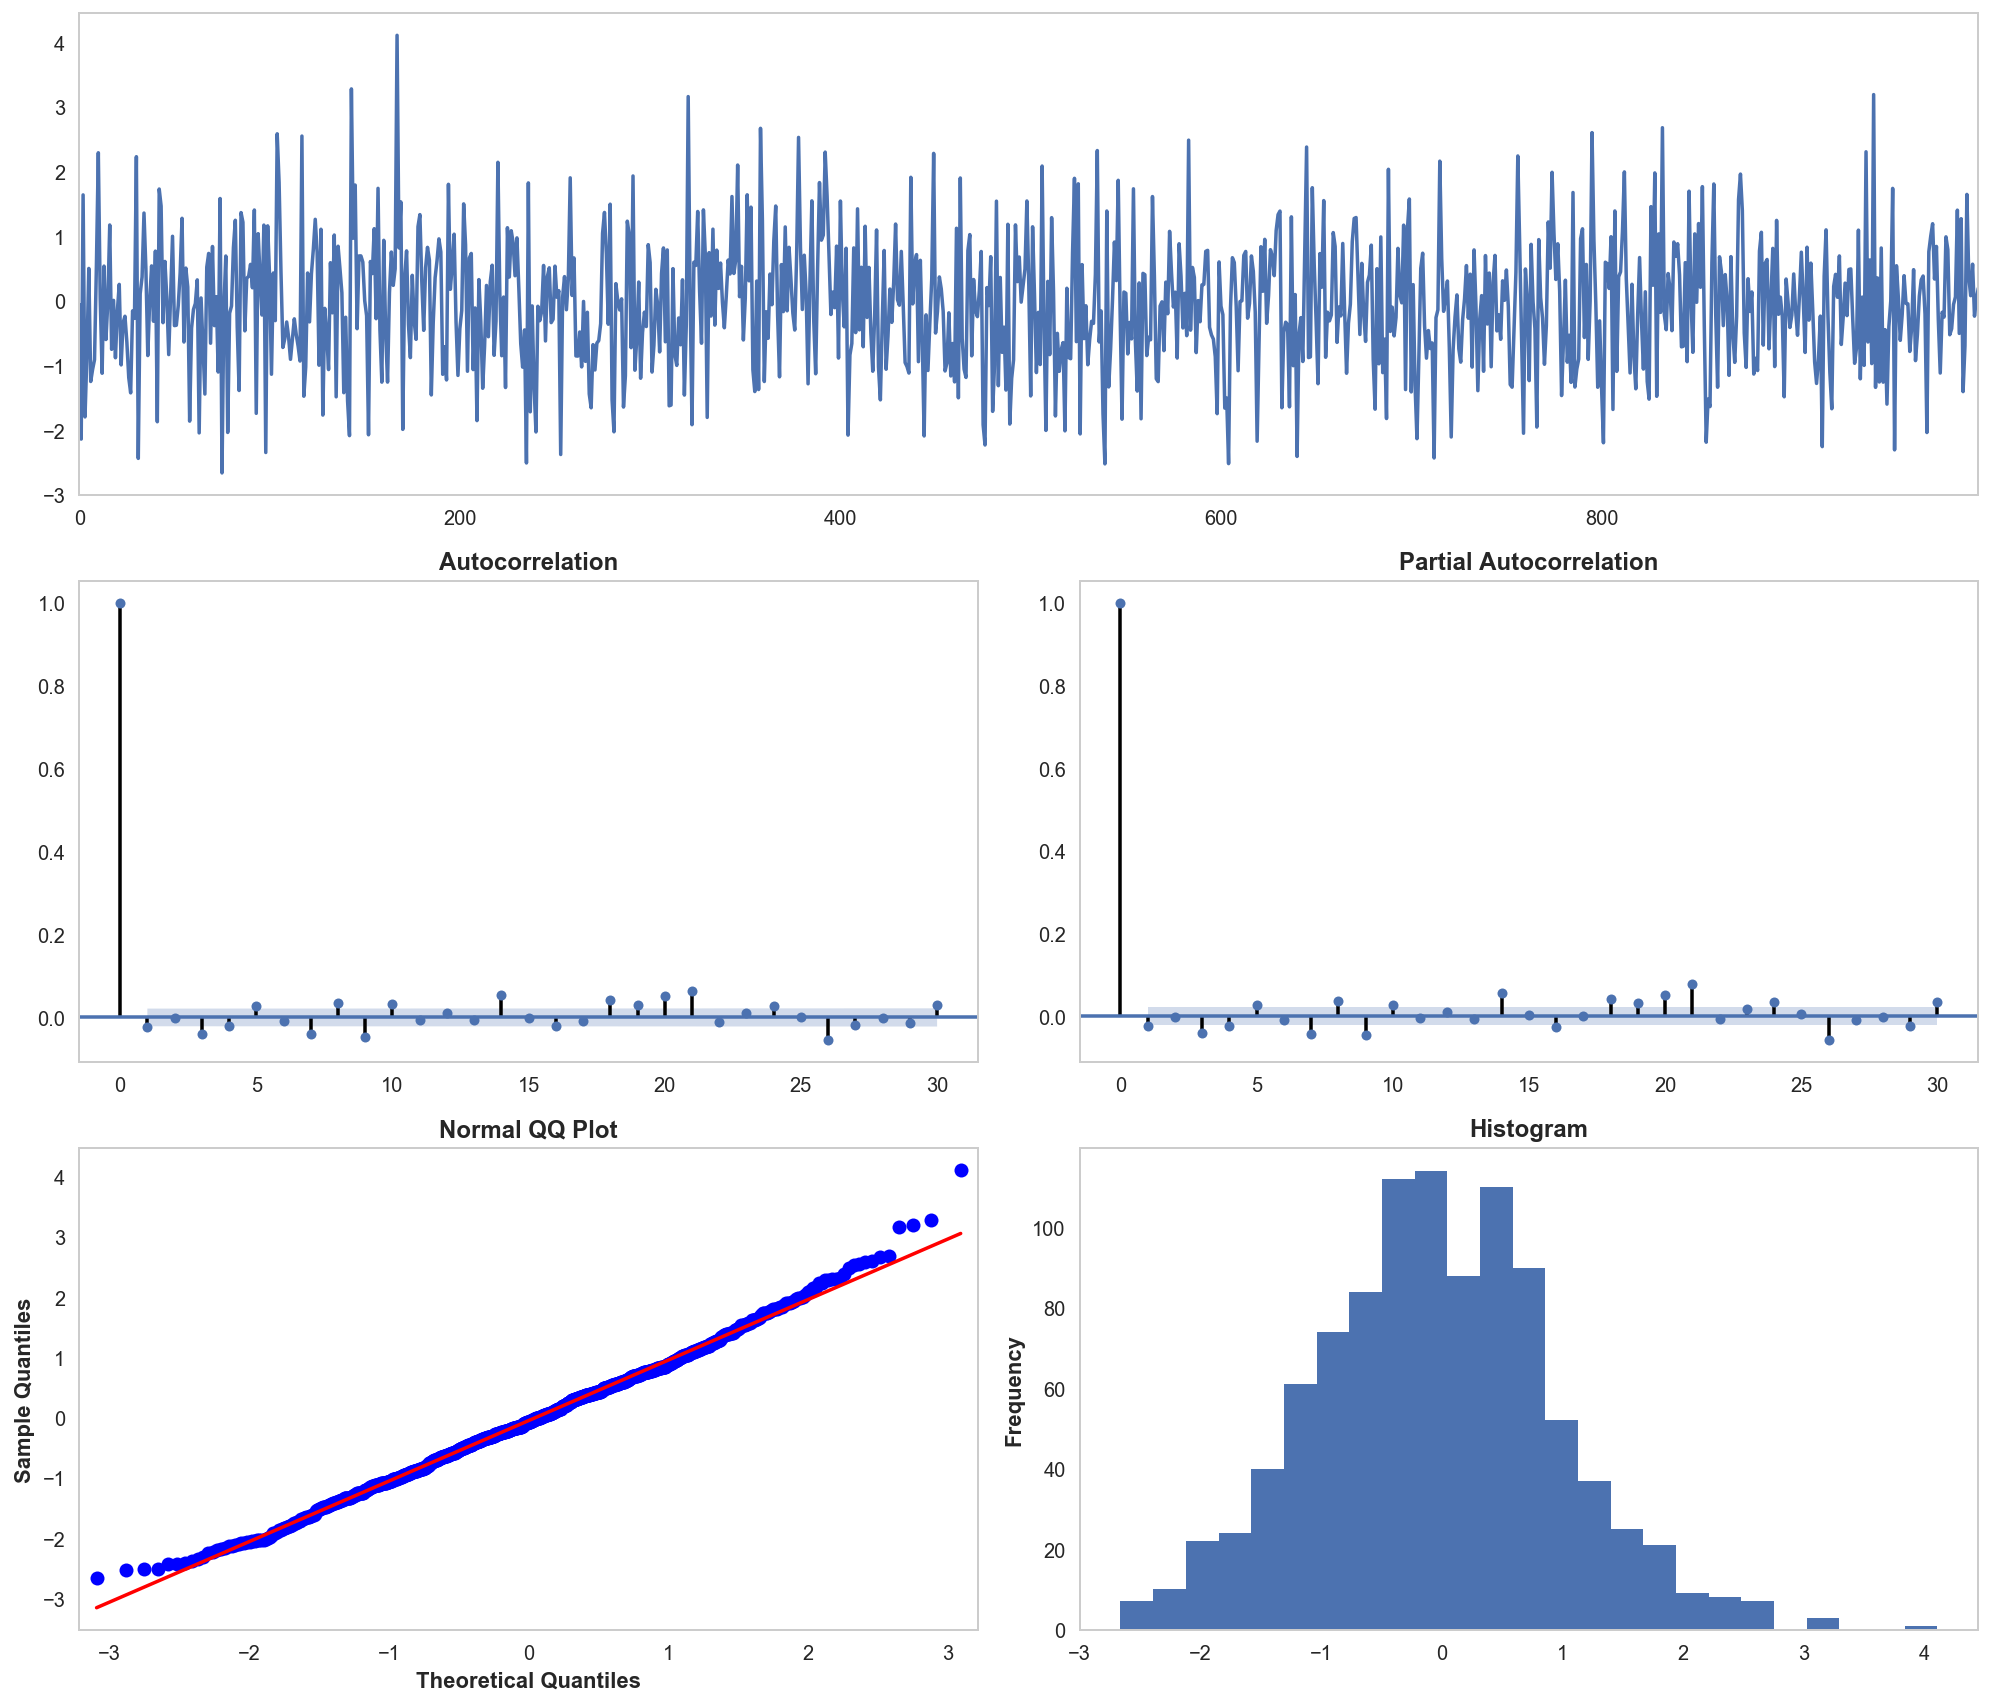

In [8]:
ts_plot(np.diff(x), lags=30)

<strong>Inference</strong>
<ul>
<li>Taking the first difference made the random walk process white noise, and hence stationary</li>
<li>No serially correlated residuals after differencing</li>
<li>Normal QQ plot and histogram indicate normally distributed errors around zero</li>
</ul>

## 2.6 Exercise

Generate data from a second order autoregressive process, $AR(2)$, with

$$
x_t = \delta + \phi_1 x_{t-1} + \phi_2 x_{t-2} + \omega_t
$$

To get you started use

In [ ]:
np.random.seed(23787)

# define parameters
n =
delta =
phi1 =
phi2 =
x = wn = np.random.normal(n)

# simulate series
for t in range(n):
    x[t] = 

Calcualte summary statistics. For example use <code>?x</code> to find out what you can do with this object. Analyse the statistical properties of this series